Sorted image files:
['IMG_1.jpg', 'IMG_2.jpg', 'IMG_3.jpg', 'IMG_4.jpg', 'IMG_5.jpg', 'IMG_6.jpg', 'IMG_7.jpg', 'IMG_8.jpg', 'IMG_9.jpg', 'IMG_10.jpg']


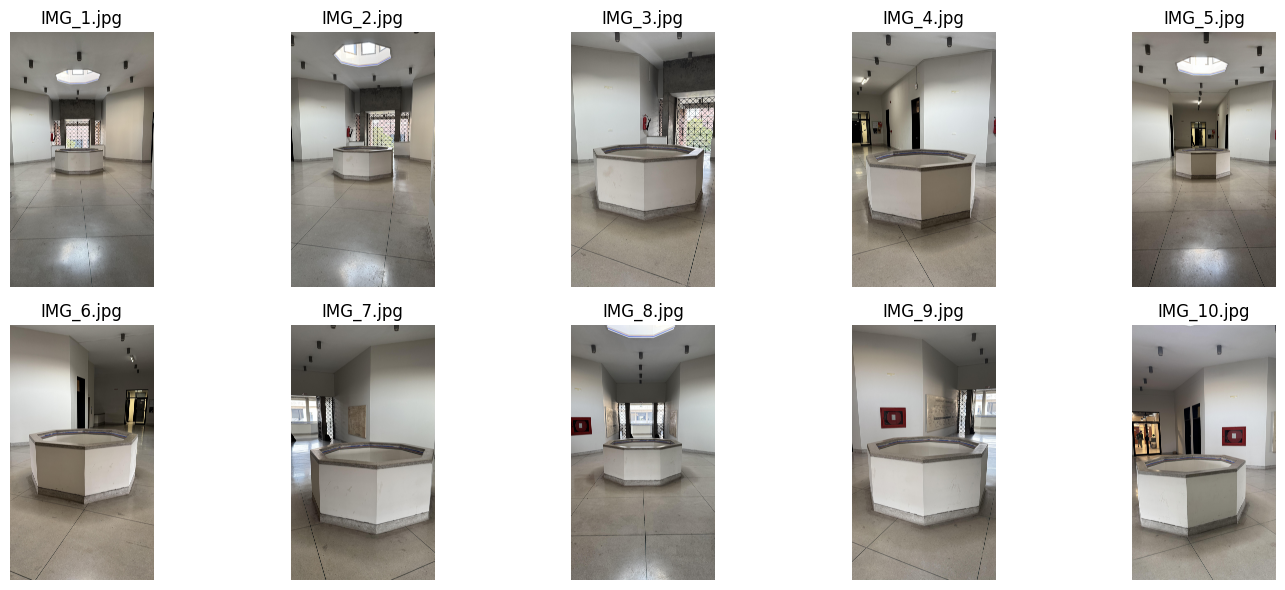

In [3]:
import matplotlib.pyplot as plt
import glob, os
import random
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import cv2
import re

def natural_sort_key(s):
    return [int(t) if t.isdigit() else t.lower()
            for t in re.split(r'(\d+)', s)]
image_folder = "/Users/ibrahimanwar/Downloads/prep/converted_jpg"

image_paths = sorted(
    [os.path.join(image_folder, f) 
     for f in os.listdir(image_folder) 
     if f.lower().endswith((".jpg", ".jpeg", ".png", ".heic"))],
    key=natural_sort_key
)

print("Sorted image files:")
print([os.path.basename(p) for p in image_paths[:10]])
images = []
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        images.append(img)
num_show = min(10, len(images))
first_images = images[:num_show]

plt.figure(figsize=(15, 6))
for i, img in enumerate(first_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(os.path.basename(image_paths[i]))

plt.tight_layout()
plt.show()


Saved 26 images to: converted_images_preprocessed


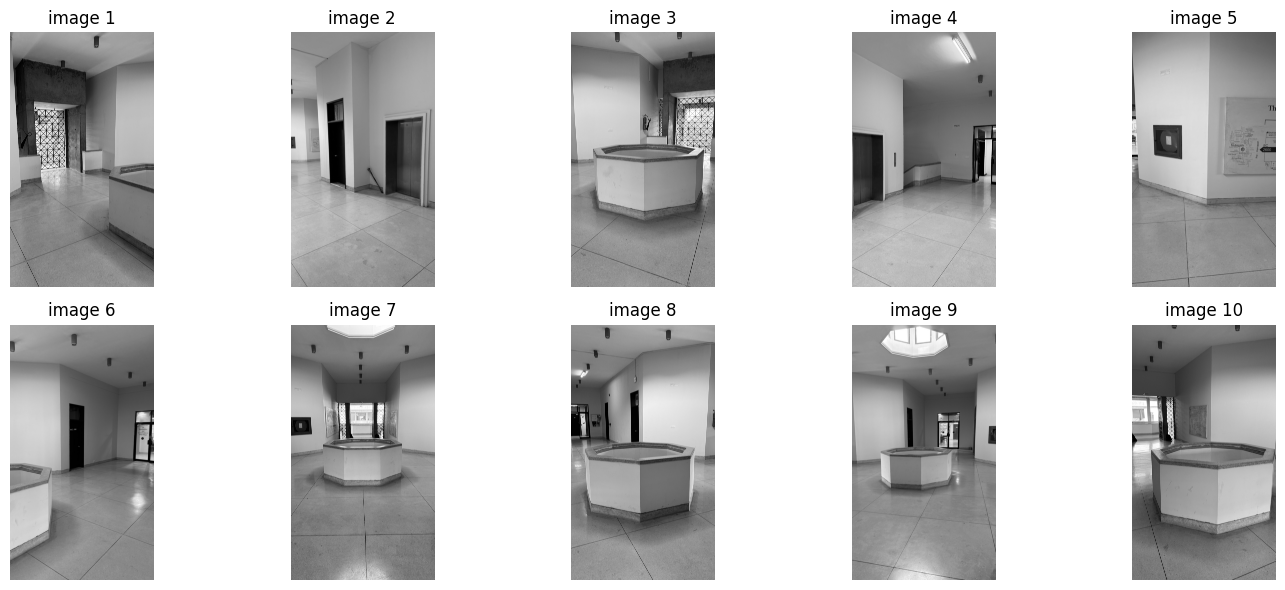

In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

output_dir = "converted_images_preprocessed"
os.makedirs(output_dir, exist_ok=True)
preprocessed_images = []

for idx, img in enumerate(images):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharp = cv2.filter2D(blur, -1, kernel)
    lap = cv2.Laplacian(blur, cv2.CV_64F)
    lap = cv2.convertScaleAbs(lap)
    enhanced = cv2.addWeighted(blur, 1.0, lap, 0.3, 0)
    final_img = enhanced
    preprocessed_images.append(final_img)
    save_path = os.path.join(output_dir, f"img_{idx:04d}.png")
    cv2.imwrite(save_path, final_img)

print(f"Saved {len(preprocessed_images)} images to: {output_dir}")
plt.figure(figsize=(15,6))
for i, img in enumerate(random.sample(preprocessed_images, min(10, len(preprocessed_images)))):
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'image {i+1}')
plt.tight_layout()
plt.show()



Image 10 ↔ Image 11: Total matches = 13266, Lowe's matches = 5612


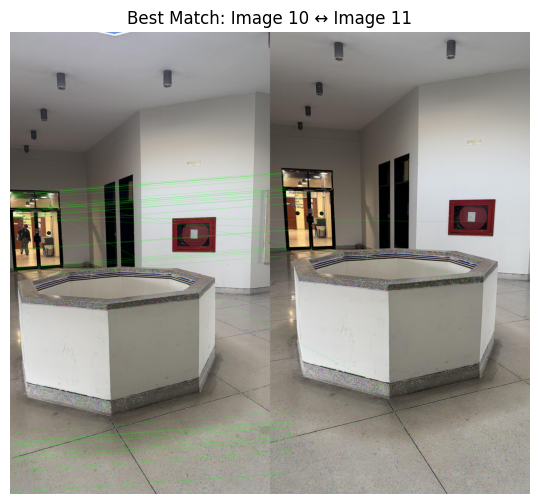

Image 23 ↔ Image 24: Total matches = 6740, Lowe's matches = 1976


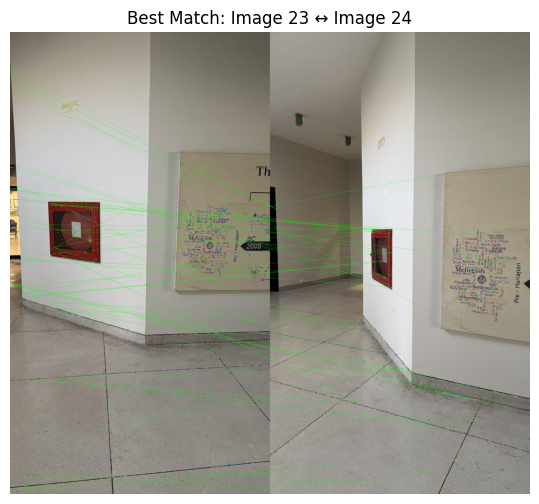

Image 3 ↔ Image 21: Total matches = 20771, Lowe's matches = 1761


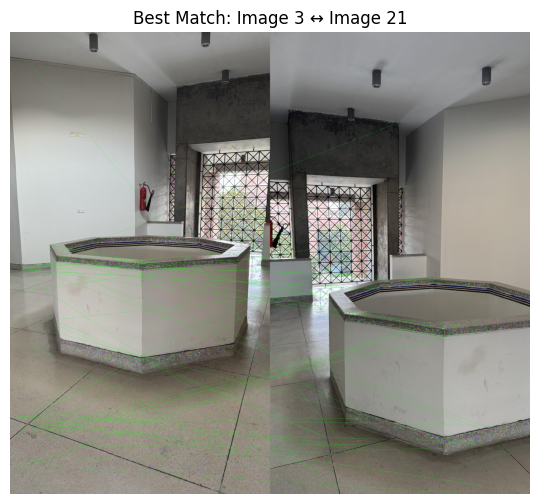

Image 1 ↔ Image 26: Total matches = 12956, Lowe's matches = 1756


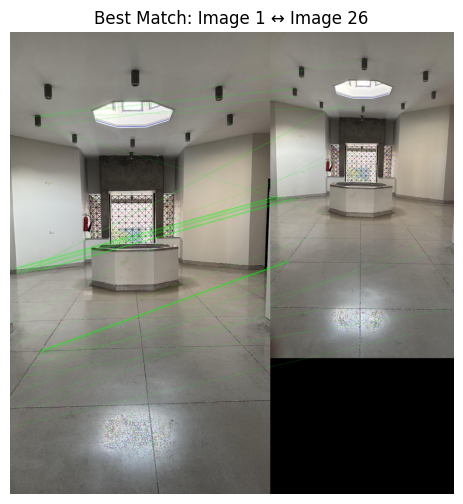

Image 7 ↔ Image 9: Total matches = 16395, Lowe's matches = 1621


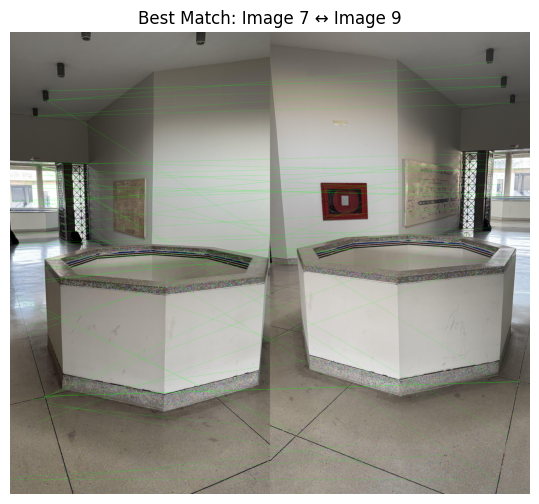

In [4]:
import numpy as np
sift = cv2.SIFT_create()
keys = []
descriptors = []
for img in preprocessed_images:
    kp, des = sift.detectAndCompute(img, None)
    keys.append(kp)
    descriptors.append(des)

bf = cv2.BFMatcher()
ratio_threshold = 0.85
pair_scores = []
for i, j in combinations(range(len(preprocessed_images)), 2):
    matches = bf.knnMatch(descriptors[i], descriptors[j], k=2)
    good_matches = []
    for m, n in matches:
        ratio = m.distance / n.distance
        if ratio < ratio_threshold:
            good_matches.append(m)
    pair_scores.append((i, j, len(matches), len(good_matches)))

pair_scores.sort(key=lambda x: x[3], reverse=True)
best_pairs = pair_scores[:5]
for i, j, total_matches, lowe_matches in best_pairs:
    matches = bf.knnMatch(descriptors[i], descriptors[j], k=2)
    good_matches = []
    for m, n in matches:
        ratio = m.distance / n.distance
        if ratio < ratio_threshold:
            good_matches.append(m)
    good_matches = good_matches[:50]
    matched_img = cv2.drawMatches(images[i], keys[i],images[j], keys[j],good_matches, None, matchColor=(0,255,0))
    print(f"Image {i+1} ↔ Image {j+1}: Total matches = {total_matches}, Lowe's matches = {lowe_matches}")
    plt.figure(figsize=(12,6))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Best Match: Image {i+1} ↔ Image {j+1}')
    plt.axis('off')
    plt.show()



K:
 [[1.500e+03 0.000e+00 1.134e+03]
 [0.000e+00 1.500e+03 2.016e+03]
 [0.000e+00 0.000e+00 1.000e+00]]

Essential Matrix E:
 [[ 0.05140889 -0.0727814  -0.18954191]
 [ 0.27508322  0.04210365 -0.62141164]
 [ 0.20565455  0.66202887  0.10937058]]

Rotation R:
 [[ 0.95799701 -0.05586191  0.28128486]
 [ 0.03386275  0.99601765  0.0824752 ]
 [-0.28477191 -0.06948592  0.95607357]]

Translation t:
 [[-0.95512707]
 [ 0.26982988]
 [-0.12216432]]

Baseline length: 1.0

Extrinsic [R|t]:
 [[ 0.95799701 -0.05586191  0.28128486 -0.95512707]
 [ 0.03386275  0.99601765  0.0824752   0.26982988]
 [-0.28477191 -0.06948592  0.95607357 -0.12216432]]

P1:
 [[1.500e+03 0.000e+00 1.134e+03 0.000e+00]
 [0.000e+00 1.500e+03 2.016e+03 0.000e+00]
 [0.000e+00 0.000e+00 1.000e+00 0.000e+00]]

P2:
 [[ 1.11406417e+03 -1.62589891e+02  1.50611472e+03 -1.57122495e+03]
 [-5.23306033e+02  1.35394286e+03  2.05115712e+03  1.58461537e+02]
 [-2.84771907e-01 -6.94859193e-02  9.56073568e-01 -1.22164324e-01]]


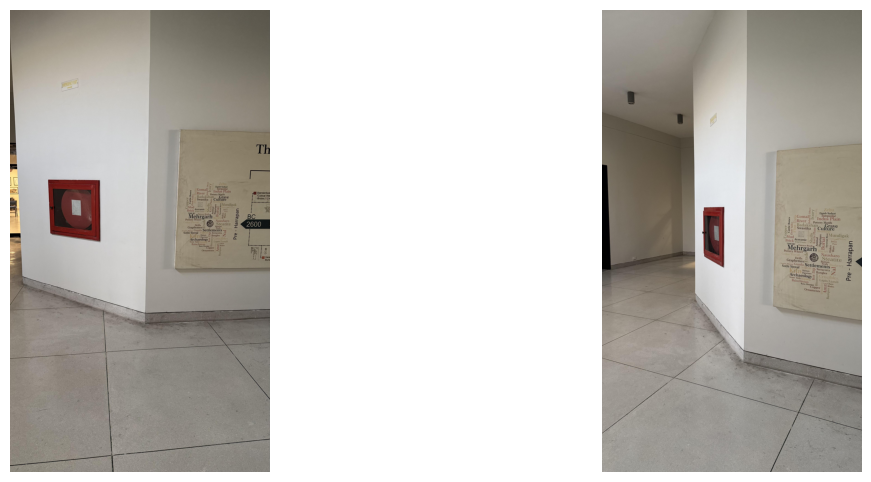

In [5]:
def disparity_score(i, j):
    matches = bf.knnMatch(descriptors[i], descriptors[j], k=2)
    good = [m for m,n in matches if m.distance < ratio_threshold * n.distance]
    if len(good) < 30:
        return 0
    pts1 = np.float32([keys[i][m.queryIdx].pt for m in good])
    pts2 = np.float32([keys[j][m.trainIdx].pt for m in good])
    return np.mean(np.linalg.norm(pts1 - pts2, axis=1))

geo_scores = []
for (i, j, _, _) in pair_scores[:20]:
    geo_scores.append((disparity_score(i, j), i, j))

geo_scores.sort(reverse=True)
_, best_i, best_j = geo_scores[0]


img1 = images[22]
img2 = images[23]
kp1 = keys[22]
kp2 = keys[23]
des1 = descriptors[22]
des2 = descriptors[23]

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis("off")


matches = bf.knnMatch(des1, des2, k=2)
good_matches = [m for m, n in matches if m.distance / n.distance < ratio_threshold]

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

h, w = img1.shape[:2]
cx, cy = w/2, h/2
fx = fy = 1500.
K = np.array([[fx,0,cx],[0,fy,cy],[0,0,1]], np.float64)
print("\nK:\n", K)

E, mE = cv2.findEssentialMat(pts1, pts2, K, cv2.RANSAC, 0.999, 1.0)
mE = mE.ravel().astype(bool)
print("\nEssential Matrix E:\n", E)
pts1 = pts1[mE]
pts2 = pts2[mE]

_, R, t, mP = cv2.recoverPose(E, pts1, pts2, K)
mP = mP.ravel().astype(bool)
pts1 = pts1[mP]
pts2 = pts2[mP]
print("\nRotation R:\n", R)
print("\nTranslation t:\n", t)
print("\nBaseline length:", np.linalg.norm(t))
print("\nExtrinsic [R|t]:\n", np.hstack((R, t)))

P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = K @ np.hstack((R, t))

pts1_h = np.asarray(pts1, dtype=np.float64).T.reshape(2, -1)
pts2_h = np.asarray(pts2, dtype=np.float64).T.reshape(2, -1)

P1 = np.asarray(P1, dtype=np.float64).reshape(3, 4)
P2 = np.asarray(P2, dtype=np.float64).reshape(3, 4)
print("\nP1:\n", P1)
print("\nP2:\n", P2)

pts4 = cv2.triangulatePoints(P1, P2, pts1_h, pts2_h)
pts3 = (pts4[:3] / pts4[3]).T
pts3 = (pts4[:3] / pts4[3]).T

mask = np.isfinite(pts3).all(axis=1)
pts3 = pts3[mask]
pts1 = pts1[mask]

pts3 -= pts3.mean(axis=0)
s = np.max(np.linalg.norm(pts3, axis=1))
pts3 /= s

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
colors = []
for u, v in pts1:
    ui, vi = int(round(u)), int(round(v))
    if 0 <= vi < img1_rgb.shape[0] and 0 <= ui < img1_rgb.shape[1]:
        colors.append(img1_rgb[vi, ui])
    else:
        colors.append([255,255,255])
colors = np.array(colors, np.uint8)

def save_ply(f, pts, col):
    with open(f, "w") as fp:
        fp.write("ply\nformat ascii 1.0\n")
        fp.write(f"element vertex {pts.shape[0]}\n")
        fp.write("property float x\nproperty float y\nproperty float z\n")
        fp.write("property uchar red\nproperty uchar green\nproperty uchar blue\nend_header\n")
        for (x,y,z),(r,g,b) in zip(pts,col):
            fp.write(f"{x} {y} {z} {r} {g} {b}\n")

save_ply("sfm_best_pair_pointcloud.ply", pts3, colors)
points_3d = pts3



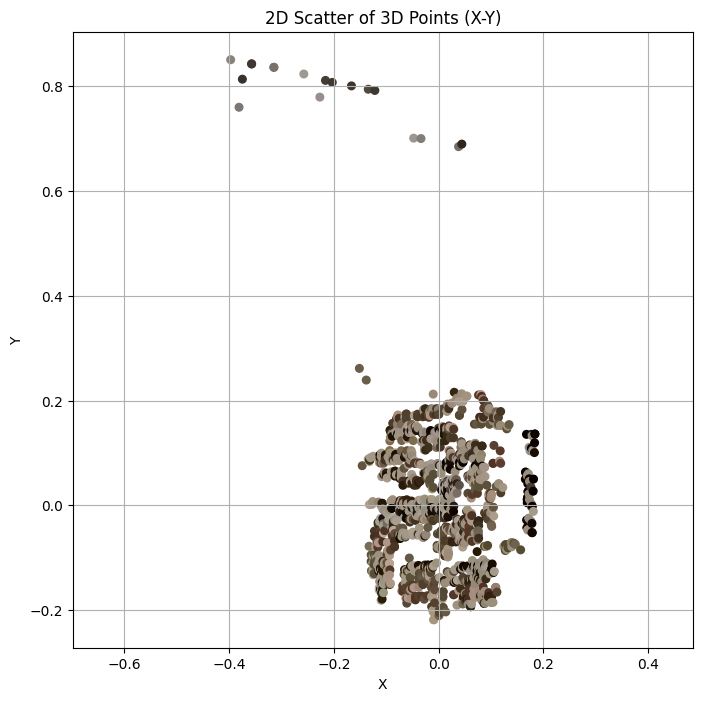

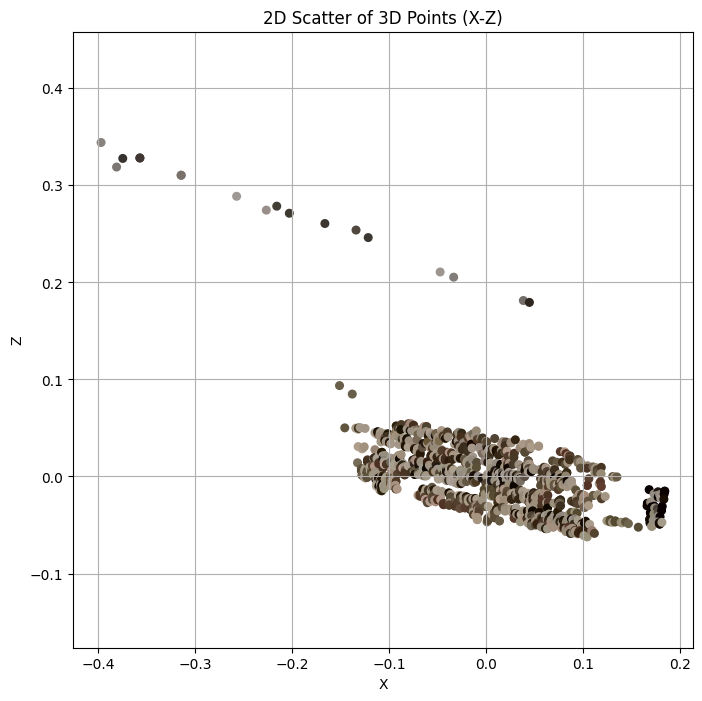

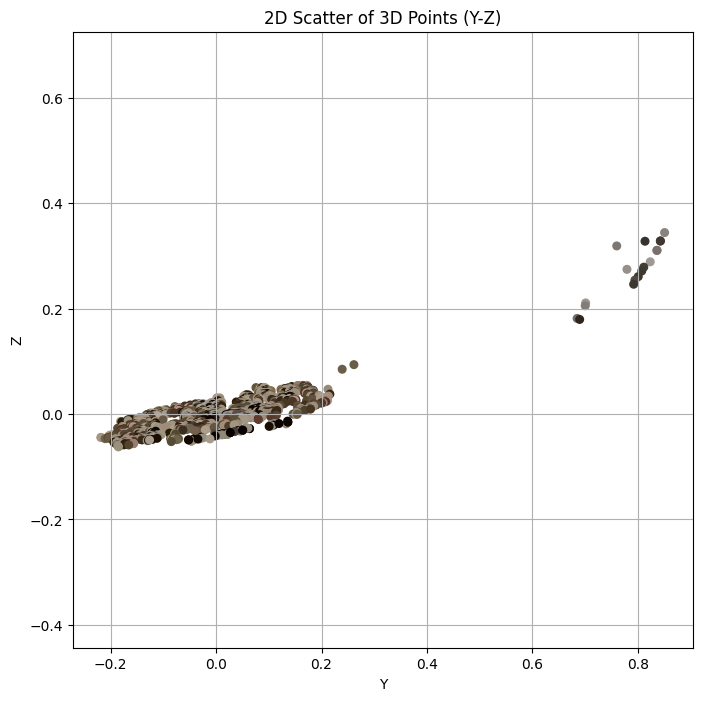

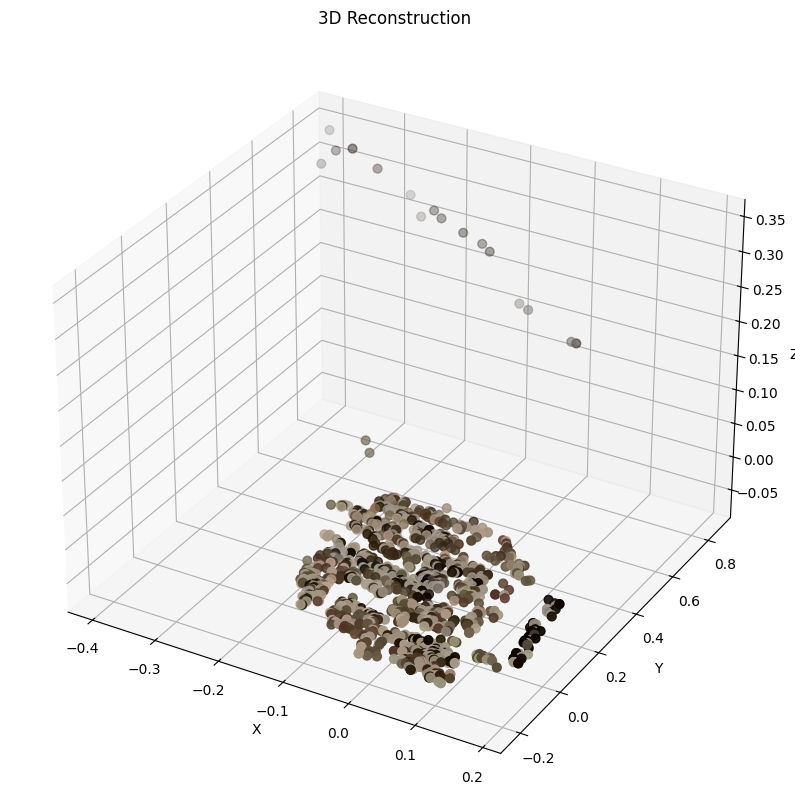

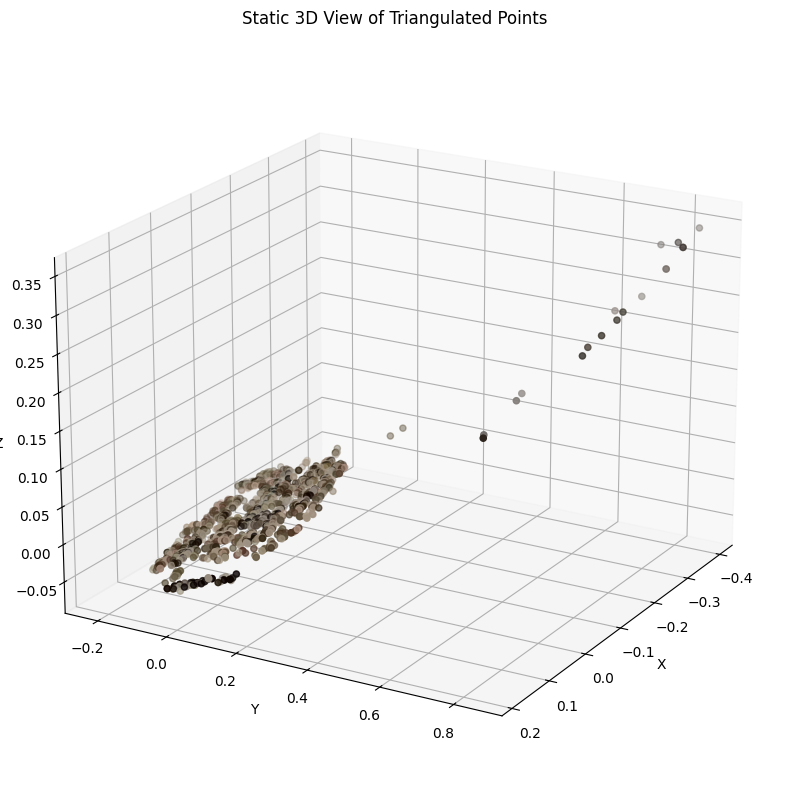

In [6]:

plt.figure(figsize=(8,8))
plt.scatter(points_3d[:,0], points_3d[:,1], c=colors/255.0, s=30)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Scatter of 3D Points (X-Y)")
plt.grid(True)
plt.axis('equal')
plt.show()
plt.figure(figsize=(8,8))
plt.scatter(points_3d[:,0], points_3d[:,2], c=colors/255.0, s=30)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("2D Scatter of 3D Points (X-Z)")
plt.grid(True)
plt.axis('equal')
plt.show()
plt.figure(figsize=(8,8))
plt.scatter(points_3d[:,1], points_3d[:,2], c=colors/255.0, s=30)
plt.xlabel("Y")
plt.ylabel("Z")
plt.title("2D Scatter of 3D Points (Y-Z)")
plt.grid(True)
plt.axis('equal')
plt.show()



fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:,0], points_3d[:,1], points_3d[:,2], 
           c=colors/255.0, s=40)
ax.set_title("3D Reconstruction")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.show()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

xs = points_3d[:,0]
ys = points_3d[:,1]
zs = points_3d[:,2]

ax.scatter(xs, ys, zs, c=colors/255, s=20)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Static 3D View of Triangulated Points')

ax.view_init(elev=20, azim=30)
plt.show()


In [7]:
import subprocess
from PIL import Image, ExifTags
import numpy as np

def heic_to_jpg_sips(heic_path, out_path):
    subprocess.run(["sips", "-s", "format", "jpeg", heic_path, "--out", out_path])

def extract_focal_mm(val):
    if hasattr(val, "numerator") and hasattr(val, "denominator"):
        return val.numerator / val.denominator
    if isinstance(val, tuple) and len(val) == 2:
        return val[0] / val[1]
    return float(val)

def get_focal_length_px_jpg(img_path, sensor_width_mm=5.76):
    img = Image.open(img_path)
    exif = img._getexif()
    if exif is None:
        return None

    fx_mm = None
    for tag, val in exif.items():
        name = ExifTags.TAGS.get(tag)
        if name == "FocalLength":
            fx_mm = extract_focal_mm(val)
            break

    if fx_mm is None:
        return None

    width = img.size[0]
    fx_px = width * (fx_mm / sensor_width_mm)
    return fx_px

def get_intrinsics_from_heic(heic_path):
    jpg_path = heic_path.replace(".HEIC", "_temp_exif.jpg")
    heic_to_jpg_sips(heic_path, jpg_path)

    fx = get_focal_length_px_jpg(jpg_path)
    img = Image.open(jpg_path)
    W, H = img.size

    if fx is None:
        fx = 1900.0

    K = np.array([
        [fx, 0, W/2],
        [0, fx, H/2],
        [0,  0,   1]
    ], dtype=np.float64)

    return K, fx, W, H

heic_path = "/Users/ibrahimanwar/Downloads/prep/IMG_10.HEIC"
K, fx, W, H = get_intrinsics_from_heic(heic_path)

print("Focal length (px):", fx)
print("Image size:", W, H)
print("Intrinsic matrix K:\n", K)


/Users/ibrahimanwar/Downloads/prep/IMG_10.HEIC
  /Users/ibrahimanwar/Downloads/prep/IMG_10_temp_exif.jpg
Focal length (px): 3773.6014875594487
Image size: 3213 5712
Intrinsic matrix K:
 [[3.77360149e+03 0.00000000e+00 1.60650000e+03]
 [0.00000000e+00 3.77360149e+03 2.85600000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import json

def parse_metashape_xml(xml_path, output_json="cameras.json"):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    camera_list = []
    for cam in root.findall(".//camera"):
        label = cam.attrib.get("label")
        transform_node = cam.find("transform")

        if transform_node is None:
            continue
        values = list(map(float, transform_node.text.strip().split()))
        M = np.array(values).reshape(4,4)

        R = M[:3,:3]
        t = M[:3, 3]
        C = -R.T @ t

        camera_list.append({
            "image": label,
            "rotation": R.tolist(),
            "translation": t.tolist(),
            "center": C.tolist()
        })

    out = {"cameras": camera_list}

    with open(output_json, "w") as f:
        json.dump(out, f, indent=2)

    print(f"Saved {len(camera_list)} cameras to {output_json}!")

parse_metashape_xml("camera_poses.xml", "cameras.json")


Saved 21 cameras to cameras.json!


In [10]:
import numpy as np
import open3d as o3d

def load_obj_pointcloud(path):
    points = []
    colors = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('v '):
                parts = line.strip().split()
                if len(parts) >= 4:
                    x, y, z = map(float, parts[1:4])
                    points.append([x, y, z])
                if len(parts) == 7:
                    r, g, b = map(float, parts[4:7])
                    colors.append([r/255, g/255, b/255])
    points = np.array(points)
    if len(colors) == len(points):
        colors = np.array(colors)
    else:
        colors = None
    return points, colors

obj_path = "final_phase3_pointcloud_i.obj"
ply_path = "cleaned_final_cloud.ply"

points, colors = load_obj_pointcloud(obj_path)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

if colors is not None:
    pcd.colors = o3d.utility.Vector3dVector(colors)

R = pcd.get_rotation_matrix_from_xyz((np.radians(-90), 0, 0))
pcd.rotate(R, center=pcd.get_center())

pcd.scale(1.0, center=pcd.get_center())

pcd = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)[0]

o3d.io.write_point_cloud(ply_path, pcd)
print("saved", ply_path)


saved cleaned_final_cloud.ply


In [11]:
import json

def build_viewgraph(cameras_json, output="viewgraph.json"):
    with open(cameras_json, 'r') as f:
        cams = json.load(f)["cameras"]

    edges = []
    n = len(cams)
    for i in range(n - 1):
        edges.append([i, i+1])

    with open(output, "w") as f:
        json.dump({"edges": edges}, f, indent=2)

    print("saved", output)

build_viewgraph("cameras.json")


saved viewgraph.json
